In [3]:
import pandas as pd
import numpy as np
import scipy.io
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import os

In [16]:
# keras library
import keras
import tensorflow as tf
import keras.preprocessing.image as image
from keras.models import Sequential, Model
from keras import metrics
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers.core import Dense
from keras.layers import GlobalAveragePooling2D
from keras.applications.resnet50 import ResNet50
import pydot, graphviz
from keras.utils import plot_model
from keras.applications.resnet50 import preprocess_input
print(keras.__version__)

2.3.1


### Data Understanding
images    -- train, val, test. Normal looking images

maps      -- train, val. grayscale points of attention 

fixations -- train, val, test.



In [5]:
# All pathing goes here

root_dir = '/home/babeen/Documents/Image Saliency Cropping/'
images_path = root_dir + 'images/'
maps_path = root_dir + 'maps/'
fixation_path = root_dir + 'fixations/'
binarized_maps_path = root_dir + 'binarized_maps/'

images_train_path = images_path + 'train/'
images_val_path = images_path + 'val/'
images_test_path = images_path + 'test/'

maps_train_path = maps_path + 'train/'
maps_val_path = maps_path + 'val/'
maps_test_path = maps_path + 'test/'

fixations_train_path = fixation_path + 'train/'
fixations_val_path = fixation_path + 'val/'
fixations_test_path = fixation_path + 'test/'

binarized_maps_train_path = binarized_maps_path + 'train/'
binarized_maps_val_path = binarized_maps_path + 'val/'
binarized_maps_test_path = binarized_maps_path + 'test/'

In [6]:
# binarization function
def binarization(img):
    # 89 is a approximation reference from paper.
    # originally in paper it mentions 0.35 as the threshold for binarization
    _, thresh1 = cv2.threshold(img, 89, 255, cv2.THRESH_BINARY)
    return thresh1

(480, 640)
(480, 640, 3)
(480, 640)


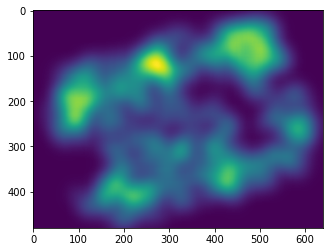

In [ ]:
# playing with data to see what can be used
mat = fixations_train_path +  'COCO_train2014_000000000009.mat'
img = images_train_path + 'data/' + 'COCO_train2014_000000000009.jpg'
mat = scipy.io.loadmat(mat)['gaze']
img = cv2.imread(img)
map_img = maps_train_path + 'data/' + 'COCO_train2014_000000000009.png'
map_img = cv2.imread(map_img, 0)
gaze_placeholder = np.zeros((img.shape[0], img.shape[1]))


for item in mat:
    item = item[0]
    location_of_gaze = item[0]
    timestamp_of_each_gaze_point = item[1]
    fixations_points = item[2]
    
    for item in location_of_gaze:
        x = int(item[0]) - 1
        y = int(item[1]) - 1
        gaze_placeholder[y, x] += 1

# binarization test
_, thresh1 = cv2.threshold(map_img, 89, 255, cv2.THRESH_BINARY) # threshold is approximated from reference
   
# plt.imshow(img[:, :, ::-1])
# plt.show()
plt.imshow(map_img[:, :])
plt.show()

# plt.imshow(gaze_placeholder)
# plt.show()

In [7]:
# Dataloader
def path_reader(path):
    list_of_path = []
    for root, folders, files in os.walk(path):
        for file in files:
            list_of_path += [root + file]
    return list_of_path

# read image
def read_images_from_path(path_list):
    imgs_list = []
    for path in path_list:
        img = image.load_img(path, grayscale=False, color_mode="rgb", target_size=None, interpolation="nearest")
        imgs_list += [img]
    imgs_list = np.vstack(imgs_list)
    return imgs_list


In [10]:
# initialized optimizers and losses
learning_rate = 0.0001
adam = optimizers.Adam(lr=learning_rate, decay=1e-7)
epochs = 10
batch_size = 2


In [18]:
# images_train_list = path_reader(images_train)
# images_val_list = path_reader(images_val)
# images_test_list = path_reader(images_test)

# maps_train_list = path_reader(maps_train)
# maps_val_list = path_reader(maps_val)
# maps_test_list = path_reader(maps_test)

# image data generator
images_train_datagen = image.ImageDataGenerator(preprocessing_function=preprocess_input)
images_val_datagen = image.ImageDataGenerator(preprocessing_function=preprocess_input)
images_test_datagen = image.ImageDataGenerator(preprocessing_function=preprocess_input)

maps_train_datagen = image.ImageDataGenerator(preprocessing_function=None)
maps_val_datagen = image.ImageDataGenerator(preprocessing_function=None)
maps_test_datagen = image.ImageDataGenerator(preprocessing_function=None)

# flow
images_train_datagen.flow_from_directory(directory=images_train_path, classes=None, class_mode=None, batch_size=16, shuffle=False)
images_val_datagen.flow_from_directory(directory=images_val_path, classes=None, class_mode=None, batch_size=16, shuffle=False)
images_test_datagen.flow_from_directory(directory=images_test_path, classes=None, class_mode=None, batch_size=16, shuffle=False)

maps_train_datagen.flow_from_directory(directory=maps_train_path, classes=None, class_mode=None, batch_size=16, shuffle=False)
maps_val_datagen.flow_from_directory(directory=maps_val_path, classes=None, class_mode=None, batch_size=16, shuffle=False)
maps_test_datagen.flow_from_directory(directory=maps_test_path, classes=None, class_mode=None, batch_size=16, shuffle=False)


Found 10000 images belonging to 1 classes.
Found 2500 images belonging to 1 classes.
Found 2500 images belonging to 1 classes.
Found 10000 images belonging to 1 classes.
Found 2500 images belonging to 1 classes.
Found 2500 images belonging to 1 classes.


In [12]:
# model initialization
def train_shallow_resnet50(weights_name='imagenet'):
    model = ResNet50(weights = weights_name)
    x = model.layers[37].output    
    x = GlobalAveragePooling2D()(x)
    x = Dense(2, activation='softmax')(x)    
    model = Model(inputs = model.input, outputs = x)
    plot_model(model, to_file='resnet.png', show_shapes=True)
    
    return model

In [17]:
# compile model
model = train_shallow_resnet50(weights_name='imagenet')
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=[metrics.categorical_accuracy])

# get items out of generators


# model.fit(images_train_datagen, None, batch_size=batch_size, epochs=epochs)

AttributeError: 'ImageDataGenerator' object has no attribute 'ndim'